In [1]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import learning_curve
import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt


# Dataset Read

In [2]:
#df=pd.read_csv('features_with_labels.csv')
df=pd.read_csv('Allfeatures_and_labels.csv')
target=df.Label
features=df.drop('IMAGE_NAME',axis='columns')
features=features.drop('Label',axis='columns')

# Feature Scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [4]:
features=pd.DataFrame(features)
features

,0,1,2,3,4,5,6
0,0.062552,0.411518,0.695633,0.195331,0.012613,0.064103,0.669950
1,0.422623,0.465129,0.604636,0.583400,0.000000,0.007326,0.754513
2,0.333178,0.267575,0.451926,0.525206,0.010383,0.102564,0.605965
3,0.214964,0.398748,0.544925,0.578566,0.054607,0.111722,0.486380
4,0.295360,0.317961,0.592465,0.105913,0.003769,0.001832,0.517865
...,...,...,...,...,...,...,...
495,0.361866,0.176585,0.320536,0.605308,0.009922,0.034799,0.656390
496,0.403441,0.358972,0.815401,0.590980,0.020458,0.064103,0.675030
497,0.238128,0.389324,0.513777,0.529739,0.000000,0.000000,0.583080
498,0.489155,0.341726,0.699732,0.465703,0.000000,0.001832,0.656151


# Feature Slection using correlation

In [5]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [6]:
corr_features = correlation(features,0.65)
len(set(corr_features))

1

In [7]:
print(corr_features)

{2}


In [8]:
features=features.drop(corr_features,axis=1)

# Model Training and accuracy measure

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree

In [11]:
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {
            'C': [10,20,23,25,27,29,26,30,35,32,33],
            'gamma':[0.51,0.52,0.55,0.57,0.61,0.63,0.65,0.71,0.81,0.91],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,15,17,19,20,22,23,25,27,30,31,33,35]
        #'n_estimators': N_ESTIMATORS
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
            #'C': LOGISTIC_C
        }
    },
    
    'Tree' : {
        'model': tree.DecisionTreeClassifier(),
        'params': {
            'criterion':['gini','entropy'],
            'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
            #'max_depth': TREE
        }
    },
    
}

In [12]:
scores = []

for model_name, mp in model_params.items():
    classifier =  GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=False)
    classifier.fit(features,target)
    scores.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_
    })
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.834,"{'C': 35, 'gamma': 0.91, 'kernel': 'rbf'}"
1,random_forest,0.852,{'n_estimators': 30}
2,logistic_regression,0.794,{'C': 10}
3,Tree,0.808,"{'criterion': 'entropy', 'max_depth': 4}"


# Learning Curve

In [13]:
S_V_M=SVC(C=20,gamma=0.91,kernel='rbf')
R_F=RandomForestClassifier(n_estimators= 33)
TR=tree.DecisionTreeClassifier(criterion='entropy',max_depth= 40)

[learning_curve] Training set sizes: [ 45  53  61  69  78  86  94 102 111 119 127 135 144 152 160 168 177 185
 193 202 210 218 226 235 243 251 259 268 276 284 292 301 309 317 326 334
 342 350 359 367 375 383 392 400 408 416 425 433 441 450]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.3s finished


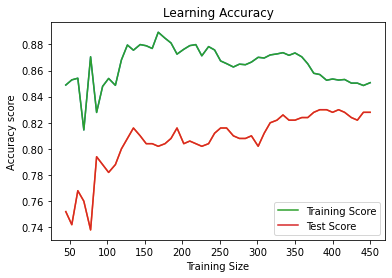

In [14]:
train_sizes,train_scores,test_scores=learning_curve(S_V_M,features,target,cv=10,scoring='accuracy',n_jobs=-1,train_sizes=np.linspace(0.1,1.0,50),verbose=1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean)
plt.plot(train_sizes,test_mean)
plt.title('Learning Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy score')

plt.plot(train_sizes,train_mean,label='Training Score')
plt.plot(train_sizes,test_mean,label='Test Score')
plt.legend(loc='best')

[learning_curve] Training set sizes: [ 45  58  72  86 100 114 128 142 156 170 184 198 212 226 240 254 268 282
 296 310 324 338 352 366 380 394 408 422 436 450]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.2s finished


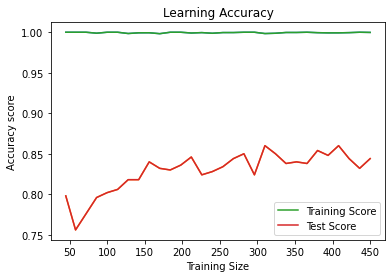

In [15]:
train_sizes,train_scores,test_scores=learning_curve(R_F,features,target,cv=10,scoring='accuracy',n_jobs=-1,train_sizes=np.linspace(0.1,1.0,30),verbose=1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean)
plt.plot(train_sizes,test_mean)
plt.title('Learning Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy score')

plt.plot(train_sizes,train_mean,label='Training Score')
plt.plot(train_sizes,test_mean,label='Test Score')
plt.legend(loc='best')

[learning_curve] Training set sizes: [ 45  58  72  86 100 114 128 142 156 170 184 198 212 226 240 254 268 282
 296 310 324 338 352 366 380 394 408 422 436 450]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.8s finished


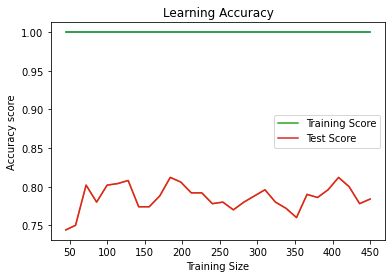

In [16]:
train_sizes,train_scores,test_scores=learning_curve(TR,features,target,cv=10,scoring='accuracy',n_jobs=-1,train_sizes=np.linspace(0.1,1.0,30),verbose=1)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean)
plt.plot(train_sizes,test_mean)
plt.title('Learning Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy score')

plt.plot(train_sizes,train_mean,label='Training Score')
plt.plot(train_sizes,test_mean,label='Test Score')
plt.legend(loc='best')

# Confussion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sn
SVM_y_pred = cross_val_predict(S_V_M, features, target, cv=10)
RF_y_pred = cross_val_predict(R_F, features, target, cv=10)
TR_y_pred = cross_val_predict(TR, features, target, cv=10)
SVM_conf_mat = confusion_matrix(target, SVM_y_pred)
RF_conf_mat = confusion_matrix(target, RF_y_pred)
TR_conf_mat = confusion_matrix(target, TR_y_pred)

Text(69.0, 0.5, 'Actual')

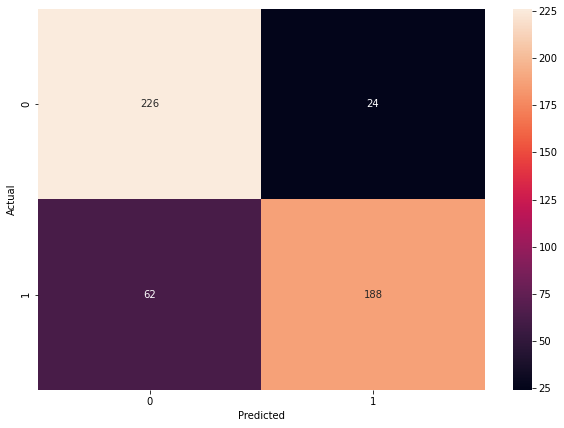

In [18]:
plt.figure(figsize=(10,7))
sn.heatmap(SVM_conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(69.0, 0.5, 'Actual')

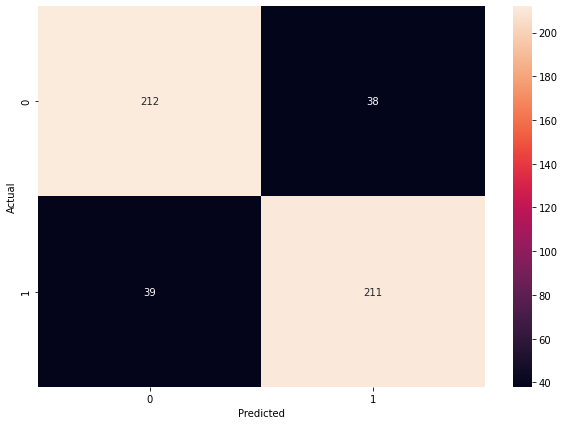

In [19]:
plt.figure(figsize=(10,7))
sn.heatmap(RF_conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(69.0, 0.5, 'Actual')

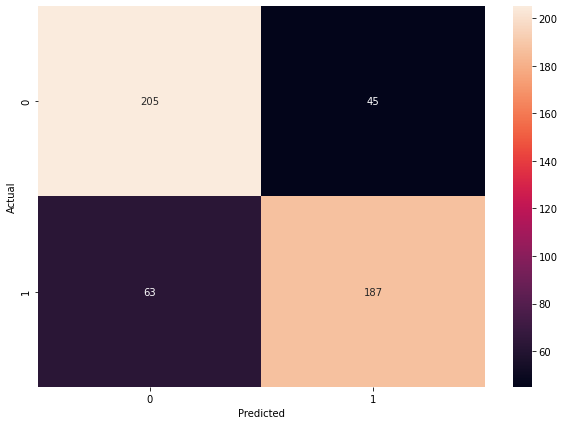

In [20]:
plt.figure(figsize=(10,7))
sn.heatmap(TR_conf_mat, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Classification Report

In [21]:
from sklearn.metrics import classification_report

In [22]:
print("SVM REPORT")
print(classification_report(target,SVM_y_pred))
print("Random REPORT")
print(classification_report(target,RF_y_pred))
print("Tree REPORT")
print(classification_report(target,TR_y_pred))

SVM REPORT
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       250
           1       0.89      0.75      0.81       250

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.84      0.83      0.83       500

Random REPORT
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       250
           1       0.85      0.84      0.85       250

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500

Tree REPORT
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       250
           1       0.81      0.75      0.78       250

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78    

# ROC and AUC Curve

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.30, random_state = 4)

In [24]:
S_V_M.fit(X_train, Y_train)
R_F.fit(X_train, Y_train)
TR.fit(X_train, Y_train)
y_pred_svm = S_V_M.predict(X_test)
y_pred_rf = R_F.predict(X_test)
y_pred_tr = TR.predict(X_test)

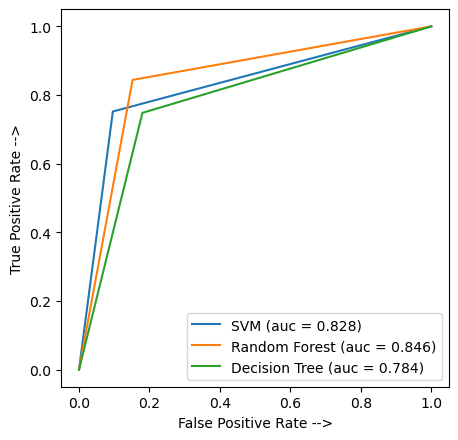

In [25]:
from sklearn.metrics import roc_curve, auc

#logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
#auc_logistic = auc(logistic_fpr, logistic_tpr)


#for train test split
#svm_fpr, svm_tpr, threshold_svm = roc_curve(Y_test, y_pred_svm)
#auc_svm = auc(svm_fpr, svm_tpr)
#for All
svm_fpr, svm_tpr, threshold_svm = roc_curve(target, SVM_y_pred)
auc_svm = auc(svm_fpr, svm_tpr)

#for train test split
#rf_fpr, rf_tpr, threshold_rf = roc_curve(Y_test, y_pred_rf)
#auc_rf = auc(rf_fpr, rf_tpr)

#for All
rf_fpr, rf_tpr, threshold_rf = roc_curve(target, RF_y_pred )
auc_rf = auc(rf_fpr, rf_tpr)

#for train test split
#tr_fpr, tr_tpr, threshold_tr = roc_curve(Y_test, y_pred_tr)
#auc_tr = auc(tr_fpr, tr_tpr)

#for All
tr_fpr, tr_tpr, threshold_tr = roc_curve(target, TR_y_pred)
auc_tr = auc(tr_fpr, tr_tpr)



plt.figure(figsize=(5, 5), dpi=100)


plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
#plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(rf_fpr, rf_tpr, linestyle='-', label='Random Forest (auc = %0.3f)' % auc_rf)
plt.plot(tr_fpr, tr_tpr, linestyle='-', label='Decision Tree (auc = %0.3f)' % auc_tr)


plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()